In [83]:
# Importando bibliotecas que vamos utilizar
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import mplcyberpunk

import warnings
warnings.filterwarnings('ignore')

In [84]:
## Aqui vou extrair novamente os dados direto do site
## para deixar o código simples caso precise rodar novamente
## (visando que sao poucos dados para extrair)

# Realizar o web scraping para obter os dados
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extrair os dados da tabela que desejamos
table = soup.find('table', {'class': 'dxgvTable'})
rows = table.find_all('tr')

In [85]:
# Criar listas para armazenar os dados
dates = []
prices = []

# Iterar sobre as linhas da tabela e extrair os dados
for row in rows[3:]:  # Ignorando o cabeçalho da tabela
    cols = row.find_all('td')
    date = cols[0].get_text().strip()
    price = float(cols[1].get_text().strip().replace(',', '.'))
    dates.append(date)
    prices.append(price)

# Criar DataFrame com os dados extraídos
df = pd.DataFrame({'Date': dates, 'Price': prices})

# Converter a coluna 'Date' para o formato datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [86]:
# Antes de treinar o modelo, vou recortar apenas os ultimos 5 anos
# Nao há a necessidade de usar os dados do periodo todo
df = df[df.Date >= '2019-01-01']

In [87]:
# Definir a data como o índice do DataFrame
df.set_index('Date', inplace=True)

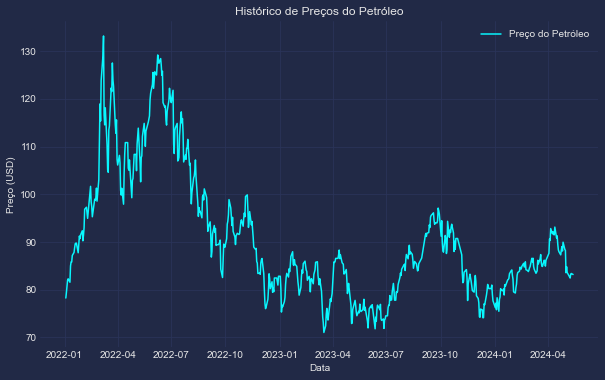

In [88]:
# Escolhendo a paleta da visao 
plt.style.use("cyberpunk")

# Visualizar os dados
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Price'], label='Preço do Petróleo')
plt.title('Histórico de Preços do Petróleo')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

In [89]:
# Dividir os dados em conjuntos de treinamento e teste
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Verificar tipos de dados do conjunto de treinamento
print(train_data.dtypes)

Price    float64
dtype: object


In [90]:
# Converter os preços para float
train_data['Price'] = train_data['Price'].astype(float)

---ARIMA---
MSE: 272.2059710570198
MAE: 13.395119741631465


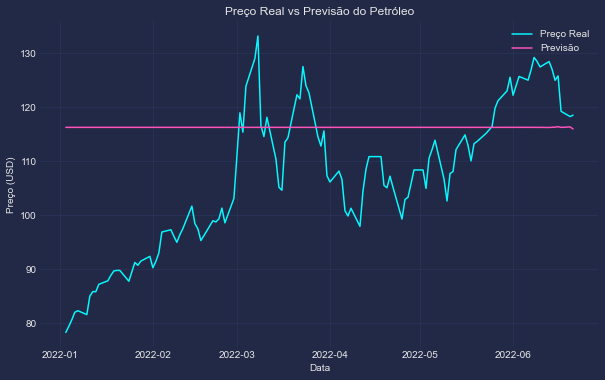

In [91]:
# Criar e treinar o modelo ARIMA
model = ARIMA(train_data, order=(5, 1, 0))
arima_model = model.fit()

# Fazer previsões para o conjunto de teste
predictions = arima_model.forecast(steps=len(test_data))

# Calcular métricas de erro
mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)

print(f'---ARIMA---')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# Plotar preços reais e previsões
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Price'], label='Preço Real')
plt.plot(test_data.index, predictions, label='Previsão')
plt.title('Preço Real vs Previsão do Petróleo')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

---SARIMA---
MSE: 482.8624875797033
MAE: 17.653817561819224


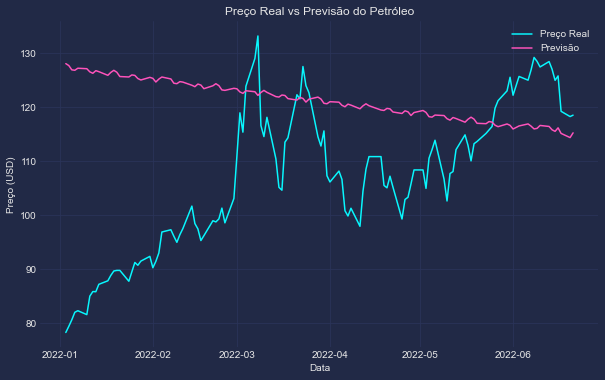

In [92]:
# Criar e treinar o modelo SARIMA
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model = model.fit()

# Fazer previsões para o conjunto de teste
predictions = sarima_model.forecast(steps=len(test_data))

# Calcular métricas de erro
mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)

print(f'---SARIMA---')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# Plotar preços reais e previsões
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Price'], label='Preço Real')
plt.plot(test_data.index, predictions, label='Previsão')
plt.title('Preço Real vs Previsão do Petróleo')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()